## Logistic Regression analysis on playlists

This jupyter notebook takes data collected from `playlist_downloader.ipynb`, and performs a series of Logicistic Regression tests to build a classifier for musical genres.

Some references I used along the way:
*   [Spotipy github project](https://github.com/plamere/spotipy)
*   [Don't sweat the solver stuff](https://towardsdatascience.com/dont-sweat-the-solver-stuff-aea7cddc3451)
*   [GridSearch for HyperParameter tuning](https://towardsdatascience.com/grid-search-for-hyperparameter-tuning-9f63945e8fec)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from matplotlib import colors
from matplotlib.ticker import PercentFormatter

# Log Reg and LDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.utils.extmath import cartesian
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from statsmodels.stats.outliers_influence import variance_inflation_factor

from scipy.special import logit

import warnings
warnings.filterwarnings('ignore')

sns.set_palette("husl")

# Setup

In [2]:
rock_rap_df = pd.read_csv("data/rock_rap_playlist.csv")
rock_country_df = pd.read_csv("data/rock_country_playlist.csv")
rap_country_df = pd.read_csv("data/rap_country_playlist.csv")

In [3]:
# Global values for the whole notebook.

# Removed [type, id, uri, track_hhref, analysis_url]
X_COLS = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']

Y_COL = ["genre_tag"]

TEST_SIZE = 0.3
SEED = 2398712

LOG_REG_SOLVERS = ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga']

# Analysis

### Step 1 - Verify assumptions

Since we will be applying logistic regression, we have the following assumptions:

#### Multicollinearity

We will look at multicollinearity below, though, our primary goal is prediction rather than explaining the roles of each variable. We will execute both models to compare their accuracy, but will ultimately use all predictors in our final accuracy. [[Source](https://statisticsbyjim.com/regression/multicollinearity-in-regression-analysis/), [Source 2](https://statisticalhorizons.com/multicollinearity), [Source 3](https://etav.github.io/python/vif_factor_python.html)]

#### Independent sampling

I'm not sure exactly how these playlists are curated. It is assumed that the songs are all indeed "sampled" from the same genre distribution.

#### Sample size

We have enough sample data to satisfy the rule-of-thumb: 10 independent observations per predictor.




In [4]:
# This cell was run iteratively, adding columns to the drop-list until no VIF > 5
vif = pd.DataFrame()
rock_rap_drop_cols = ["energy", "danceability", "tempo", "loudness"]
rock_rap_df_ind = rock_rap_df.copy()[X_COLS].drop(rock_rap_drop_cols, axis=1)

vif["VIF"] = [variance_inflation_factor(rock_rap_df_ind.values, i) for i in range(rock_rap_df_ind.shape[1])]
vif["Features"] = rock_rap_df_ind.columns
vif.round(1)

,VIF,Features
0,2.6,key
1,2.3,mode
2,2.0,speechiness
3,1.6,acousticness
4,1.1,instrumentalness
5,2.6,liveness
6,4.2,valence


In [5]:
# This cell was run iteratively, adding columns to the drop-list until no VIF > 5
vif = pd.DataFrame()
co_rap_drop_cols = ["danceability", "energy", "loudness", "tempo"]
rap_country_df_ind = rap_country_df.copy()[X_COLS].drop(co_rap_drop_cols, axis=1)

vif["VIF"] = [variance_inflation_factor(rap_country_df_ind.values, i) for i in range(rap_country_df_ind.shape[1])]
vif["Features"] = rap_country_df_ind.columns
vif.round(1)

,VIF,Features
0,2.8,key
1,2.8,mode
2,1.8,speechiness
3,1.7,acousticness
4,1.1,instrumentalness
5,2.9,liveness
6,5.2,valence


In [6]:
# This cell was run iteratively, adding columns to the drop-list until no VIF > 5
vif = pd.DataFrame()
rock_co_drop_cols = ["energy", "danceability", "tempo", "valence"]
rock_country_df_ind = rock_country_df.copy()[X_COLS].drop(rock_co_drop_cols, axis=1)

vif["VIF"] = [variance_inflation_factor(rock_country_df_ind.values, i) for i in range(rock_country_df_ind.shape[1])]
vif["Features"] = rock_country_df_ind.columns
vif.round(1)

,VIF,Features
0,2.8,key
1,5.5,loudness
2,3.5,mode
3,2.7,speechiness
4,1.8,acousticness
5,1.1,instrumentalness
6,2.7,liveness


In [7]:
rock_rap_df_ind["genre_tag"] = rock_rap_df["genre_tag"]
rap_country_df_ind["genre_tag"] = rap_country_df["genre_tag"]
rock_country_df_ind["genre_tag"] = rock_country_df["genre_tag"]

### Step 2 - Baseline logistic regression

Run a basic logistic regression on our dataframes. Three models:

-   Rock vs Rap
-   Rap vs Country
-   Rock vs Country

For each comparison, we also check with the reduced column-set without multicollinearity.

In [8]:
def log_reg(playlist_df, x_cols, y_col):
    """ Runs a vanilla logistic regression on the playlist dataframe. Returns (model, confusion_matrix).
        Returns LogisticRegressionModel, Confusion Matrix, (X test data, Y test data)
    
        Parameters:
            - playlist_df - Spotify playlist dataframe. Should have all of the columns specified in x_cols, y_col.
            - x_cols      - Predictor columns. The columns used to train the logistic regression model. 
            - y_col       - Target column. Distinguishes between the classes of the model.
    """
    X = playlist_df[x_cols]
    Y = playlist_df[y_col]
    
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = TEST_SIZE, random_state = SEED)
    log_reg = LogisticRegression(random_state = SEED)
    
    model = log_reg.fit(x_train, y_train)
    predictions = model.predict(x_test)
    con_mat = confusion_matrix(y_test, predictions)
    predict_probs = model.predict_proba(x_test)[:,1]
    
    return con_mat, (x_test, y_test, predictions, predict_probs)


def analyze_results(con_mat, verbose = False):
    """ Analyzes the results in a confusion matrix, printing the precision, recall, specificity, accuracy, and naive
        results.
    
        Parameters:
            - con_mat: a 2x2 confusion matrix: [[TN, FP], (FN, TP)]
            - verbose: When true, prints verbose metrics.
    """
    tn, fp, fn, tp = con_mat.flatten()
    precision = (tp) / (tp + fp)
    recall = (tp) / (tp + fn)
    specificity = (tn) / (tn + fp)
    accuracy = (tp + tn) / (tn + tp + fp + fn)
    mcc = (tp * tn - fp * fn)/np.sqrt((tp + fp)*(tp + fn)*(tn + fp)*(tn + fn))    
    naive = (tn + fp) / (tn + tp + fp + fn)
    print("Prec: {:0.2f}%\tRecall: {:0.2f}%\tSpec: {:0.2f}%\tAcc: {:0.2f}%\tMcc: {:0.2f}\tNaive: {:0.2f}%\t".format(precision * 100, recall * 100, specificity * 100, accuracy * 100, mcc, naive *100))
    if (verbose):
        print("(Precision) Our positive guesses are accurate: {:0.2f}% of the time".format(precision * 100))
        print("(Recall) We correctly identify a positive case: {:0.2f}% of the time".format(recall * 100))
        print("(Specificity) We correctly identify negative cases {:0.2f}% of the time".format(specificity * 100))
        print("(Accuracy) Our model's overall guesses are correct {:0.2f}% of the time".format(accuracy * 100))
        print("(Matthew's) The Matthew's Correlation Coefficient: {:0.2f}".format(mcc))  
        print("The naive model is correct {:0.2f}% of the time".format(naive*100))

In [9]:
rock_rap_con_mat, rock_rap_test_data = log_reg(rock_rap_df, X_COLS, Y_COL)
analyze_results(rock_rap_con_mat)

trim_cols = [col for col in X_COLS.copy() if col not in rock_rap_drop_cols]
rock_rap_ind_con_mat, _ = log_reg(rock_rap_df_ind, trim_cols, Y_COL)
analyze_results(rock_rap_ind_con_mat)

Prec: 86.00%	Recall: 95.56%	Spec: 87.50%	Acc: 91.09%	Mcc: 0.83	Naive: 55.45%	
Prec: 76.74%	Recall: 73.33%	Spec: 82.14%	Acc: 78.22%	Mcc: 0.56	Naive: 55.45%	


In [10]:
rap_country_con_mat, rap_country_test_data = log_reg(rap_country_df, X_COLS, Y_COL)
analyze_results(rap_country_con_mat)

trim_cols = [col for col in X_COLS.copy() if col not in co_rap_drop_cols]
rap_country_ind_con_mat, _ = log_reg(rap_country_df_ind, trim_cols, Y_COL)
analyze_results(rap_country_ind_con_mat)

Prec: 79.55%	Recall: 85.37%	Spec: 82.00%	Acc: 83.52%	Mcc: 0.67	Naive: 54.95%	
Prec: 76.09%	Recall: 85.37%	Spec: 78.00%	Acc: 81.32%	Mcc: 0.63	Naive: 54.95%	


In [11]:
rock_country_con_mat, rock_country_test_data = log_reg(rock_country_df, X_COLS, Y_COL)
analyze_results(rock_country_con_mat)

trim_cols = [col for col in X_COLS.copy() if col not in rock_co_drop_cols]
rock_country_ind_con_mat, _ = log_reg(rock_country_df_ind, trim_cols, Y_COL)
analyze_results(rock_country_ind_con_mat)

Prec: 55.10%	Recall: 61.36%	Spec: 62.07%	Acc: 61.76%	Mcc: 0.23	Naive: 56.86%	
Prec: 55.56%	Recall: 56.82%	Spec: 65.52%	Acc: 61.76%	Mcc: 0.22	Naive: 56.86%	


### Step 4

Now that we have some baseline models, let's visualize the principal components to get a sense for a possible decision boundary. Note that we don't use the components, we just want to visualize the separation of the data in the different playlists.

In [12]:
rock_rap_df_trimmed = rock_rap_df[X_COLS]
rap_country_df_trimmed = rap_country_df[X_COLS]
rock_country_df_trimmed = rock_country_df[X_COLS]

In [13]:
# Scale the data uniformly to judge which params are most useful.
scaler = StandardScaler()
scaler.fit(rock_rap_df_trimmed) 
rock_rap_df_norm = pd.DataFrame(scaler.transform(rock_rap_df_trimmed), columns=rock_rap_df_trimmed.columns)

scaler = StandardScaler()
scaler.fit(rap_country_df_trimmed) 
rap_country_df_norm = pd.DataFrame(scaler.transform(rap_country_df_trimmed), columns=rap_country_df_trimmed.columns)

scaler = StandardScaler()
scaler.fit(rock_country_df_trimmed)
rock_country_df_norm = pd.DataFrame(scaler.transform(rock_country_df_trimmed), columns=rock_country_df_trimmed.columns)

In [14]:
# Find the principal components
pca = PCA(n_components = 6)
rock_rap_pca = pca.fit_transform(rock_rap_df_norm)

pca = PCA(n_components = 6)
rap_country_pca = pca.fit_transform(rap_country_df_norm)

pca = PCA(n_components = 6)
rock_country_pca = pca.fit_transform(rock_country_df_norm)

In [15]:
def plot_principal_components(pca_data, color_map, fig_title):
    """ Plots scatterplots comparing 6 principal compontents: (1,2), (3,4), (5,6). Returns the figure for saving.
    
        Parameters:
            - pca_data: 2D array returned by PCA.transform, with at least 6 components
            - color_map: a mapping for colors and styles. Should be the same length as the first axis of pca_data
            - fig_title: A title for the figure.
            
        TODO - Refactor to pass in the number of components.
    """
    fig, axes = plt.subplots(1,3,figsize=(16,6))
    fig.set_dpi(250)
    ax1, ax2, ax3 = axes.flatten()
    sns.scatterplot(x=pca_data[:,0], y=pca_data[:,1], ax = ax1,
                   hue=color_map, style=color_map)
    sns.scatterplot(x=pca_data[:,2], y=pca_data[:,3], ax = ax2,
                    hue=color_map, style=color_map)
    sns.scatterplot(x=pca_data[:,4], y=pca_data[:,5], ax = ax3,
                    hue=color_map, style=color_map)
    
    fig.suptitle(fig_title, size = 18)
    ax1.set_xlabel("First principal component", fontsize=16)
    ax1.set_ylabel("Second principal component", fontsize=16)
    ax2.set_xlabel("Third principal component", fontsize=16)
    ax2.set_ylabel("Fourth principal component", fontsize=16)
    ax3.set_xlabel("Fifth principal component", fontsize=16)
    ax3.set_ylabel("Sixth principal component", fontsize=16)
    
    ax1.legend(loc="upper right", fontsize=12, framealpha = 0.6)
    ax2.legend(loc="upper right", fontsize=12, framealpha = 0.6)
    ax3.legend(loc="upper right", fontsize=12, framealpha = 0.6)

    return fig

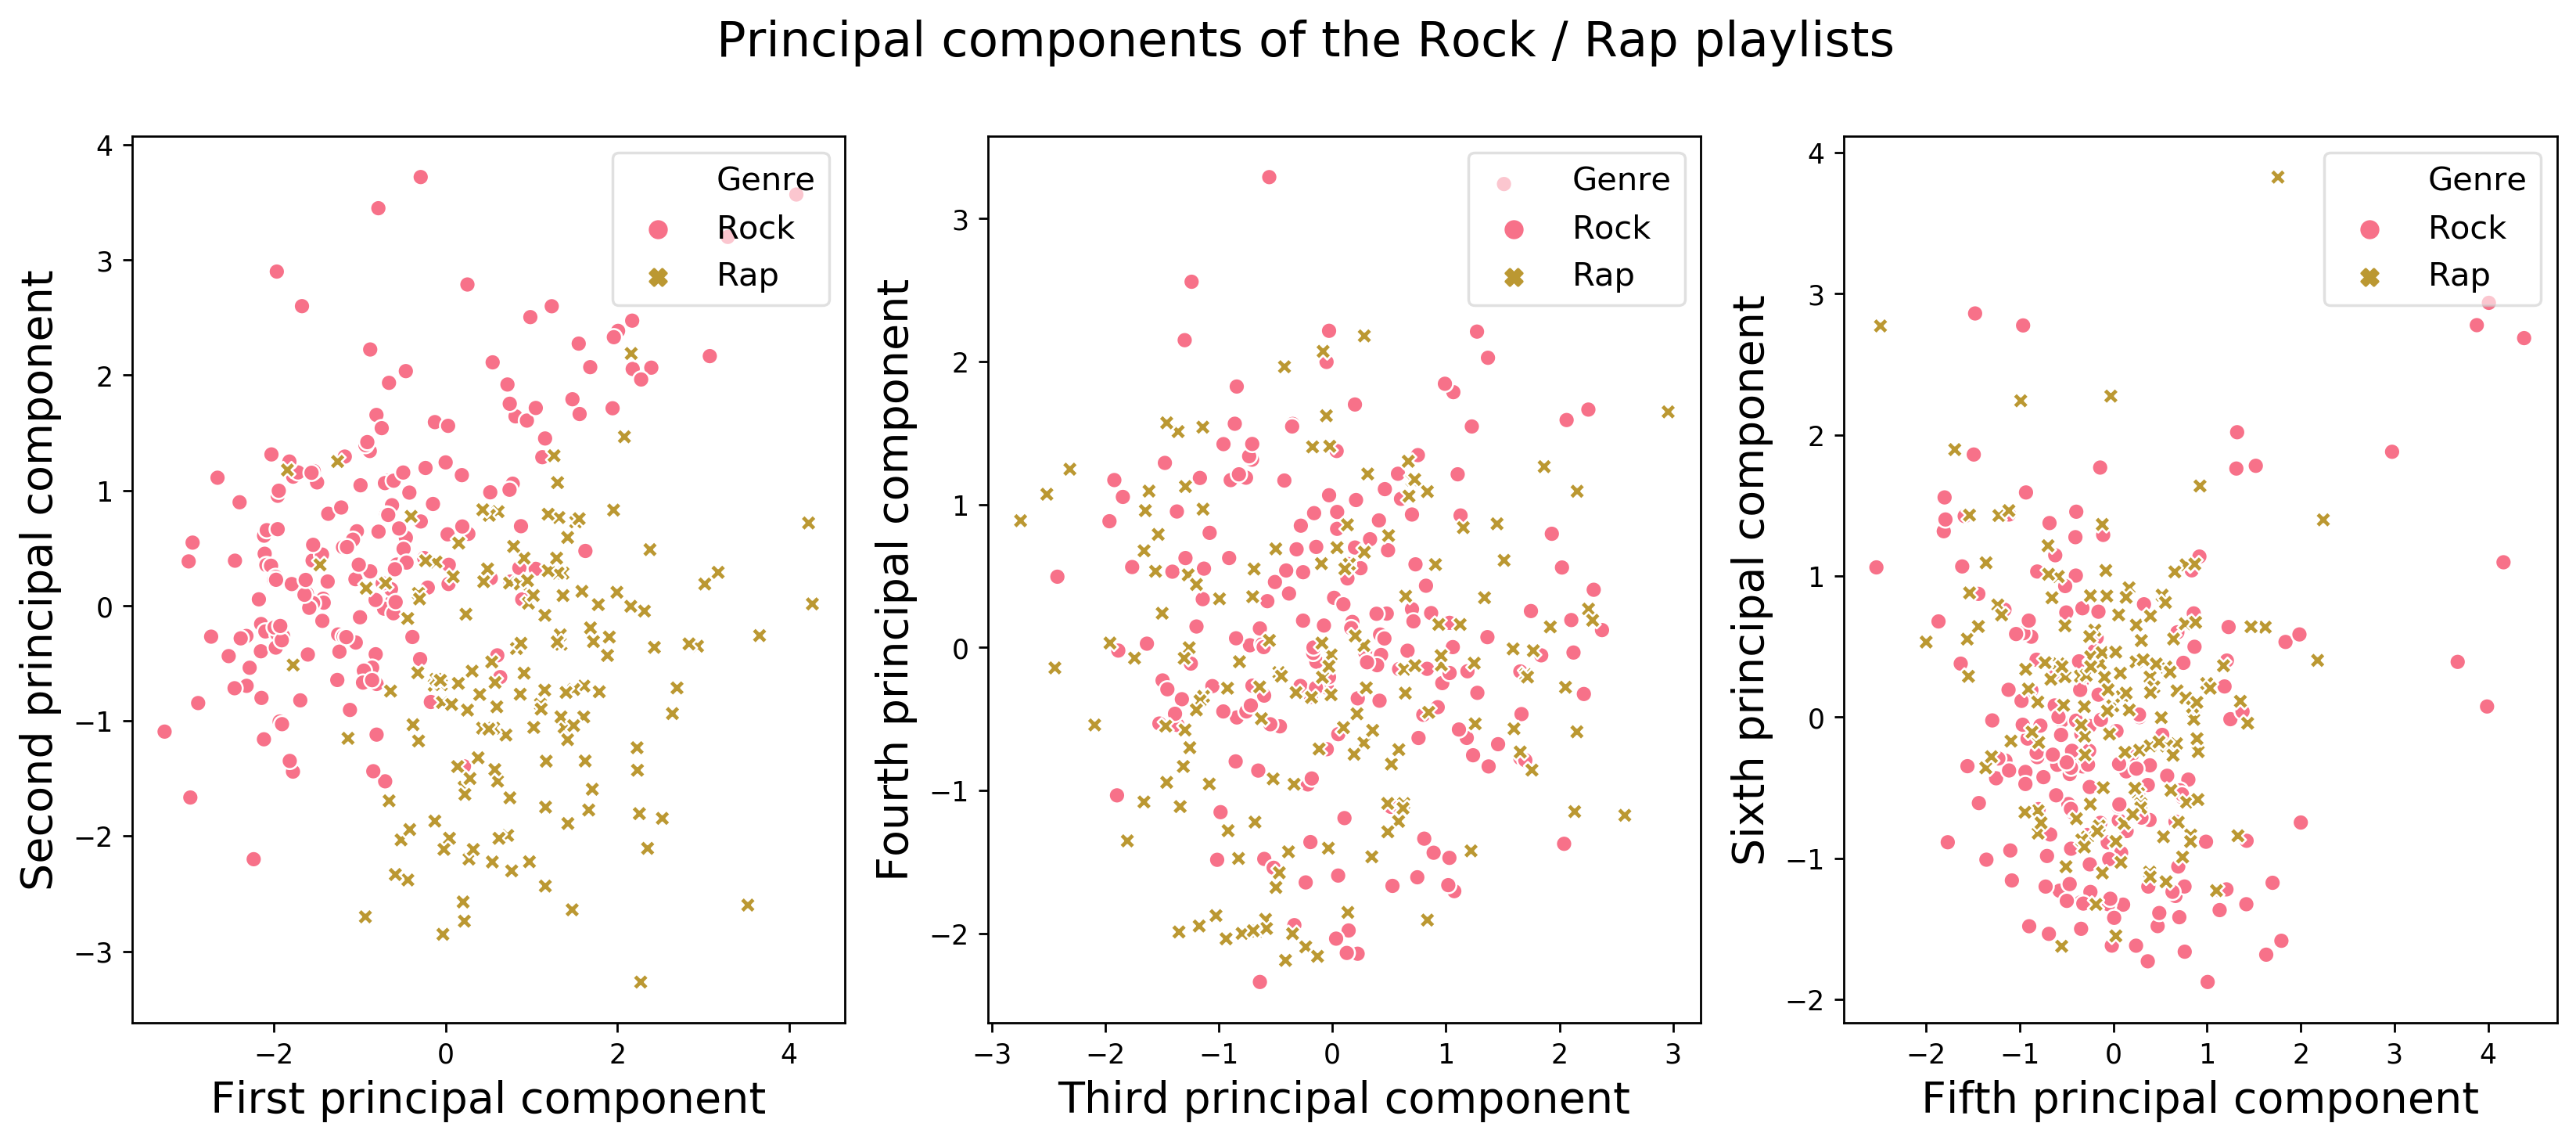

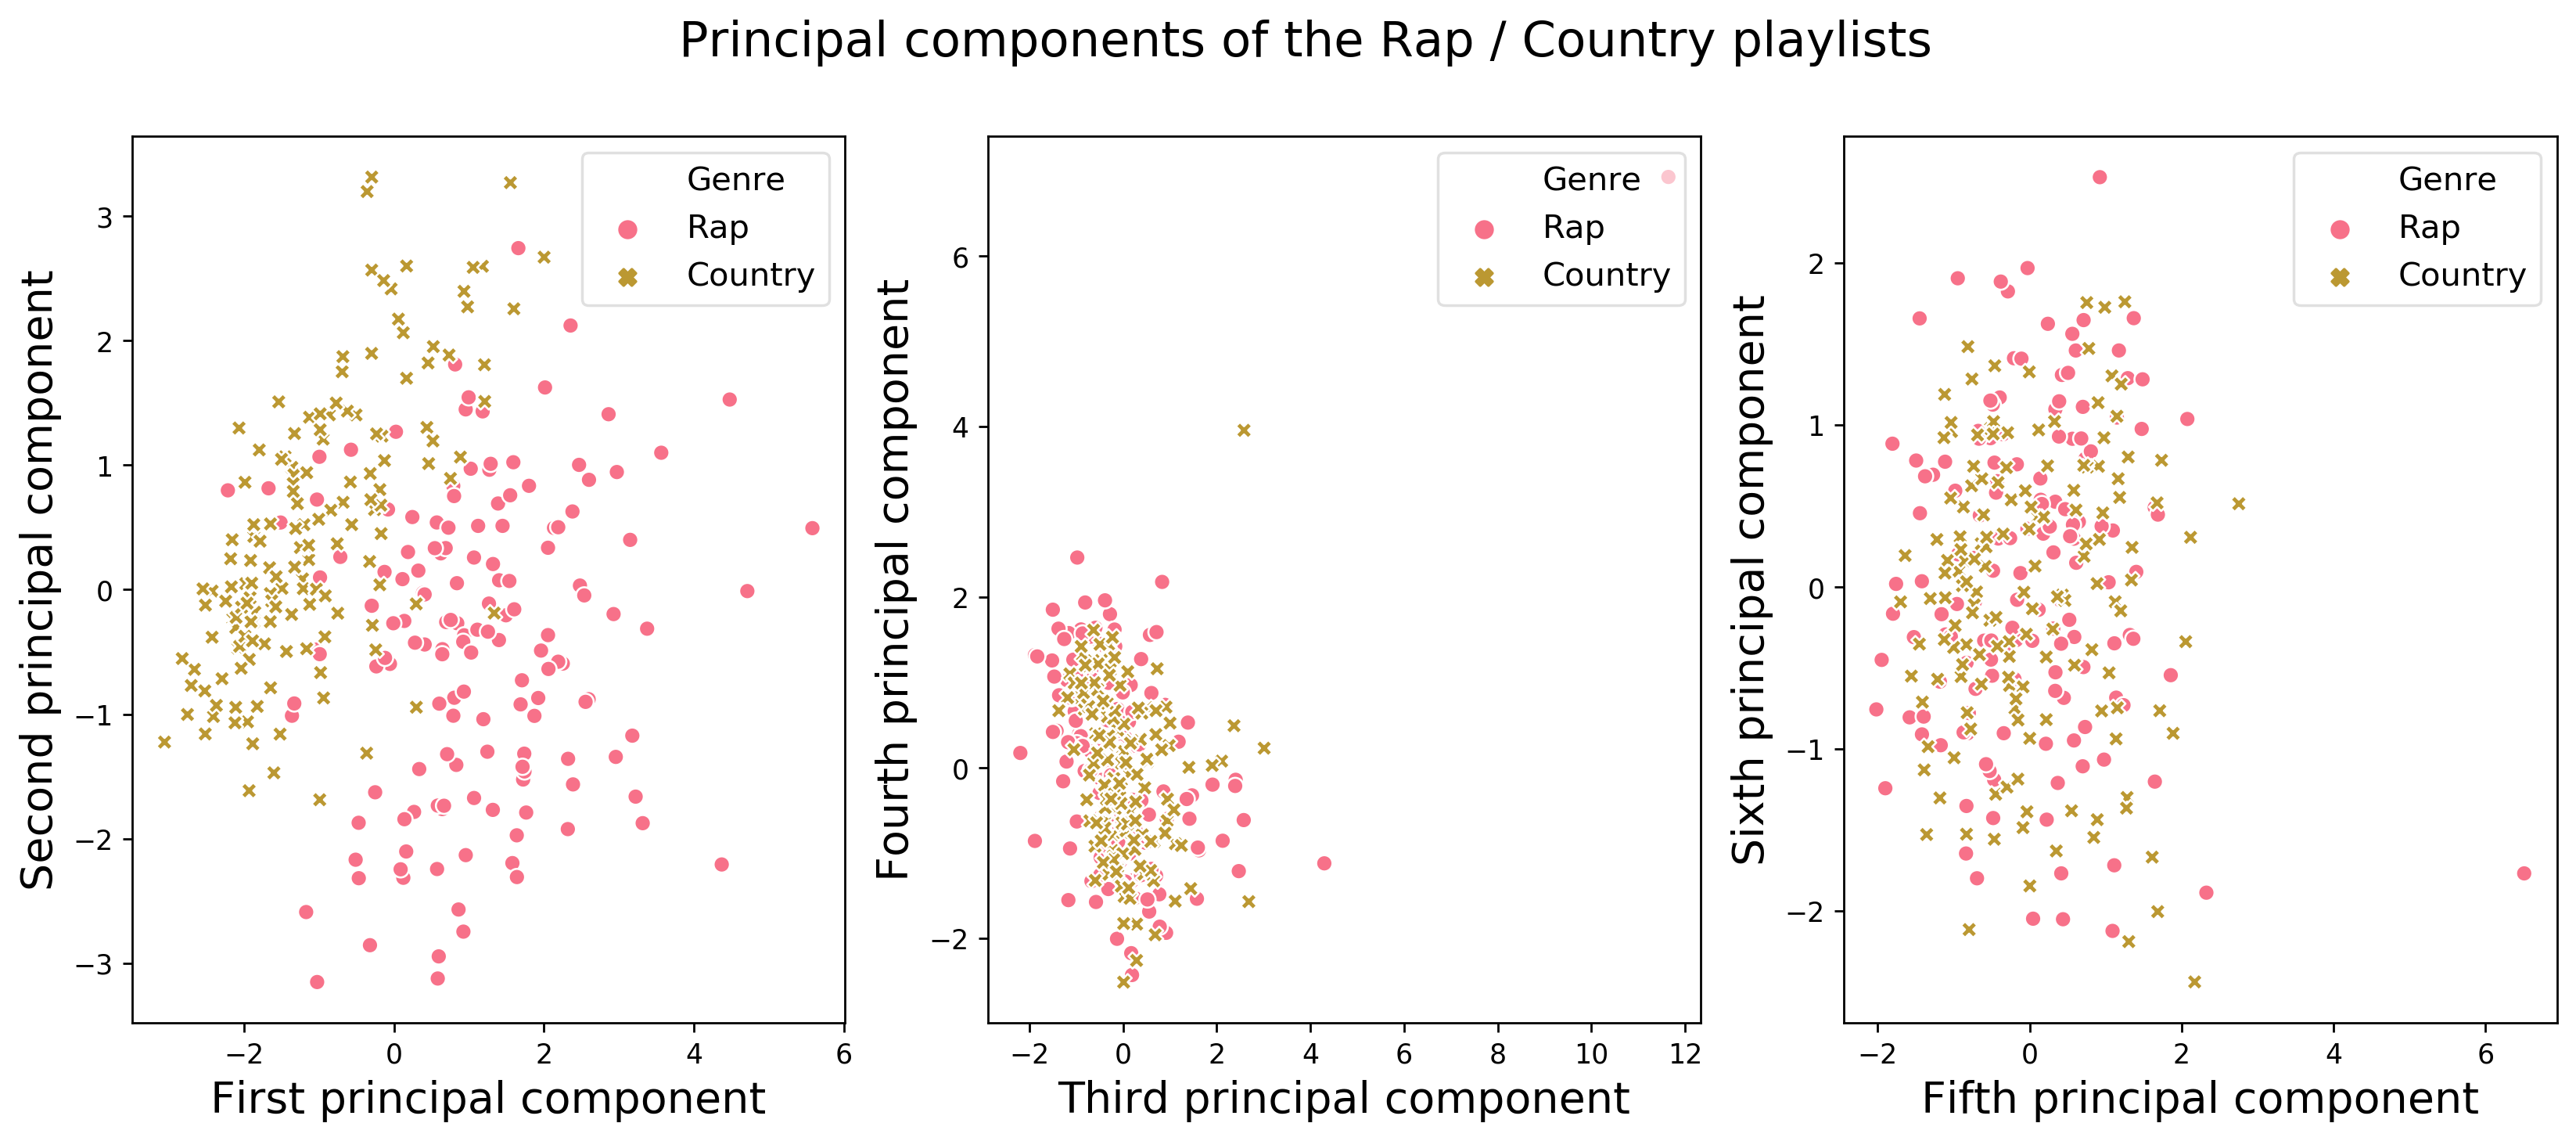

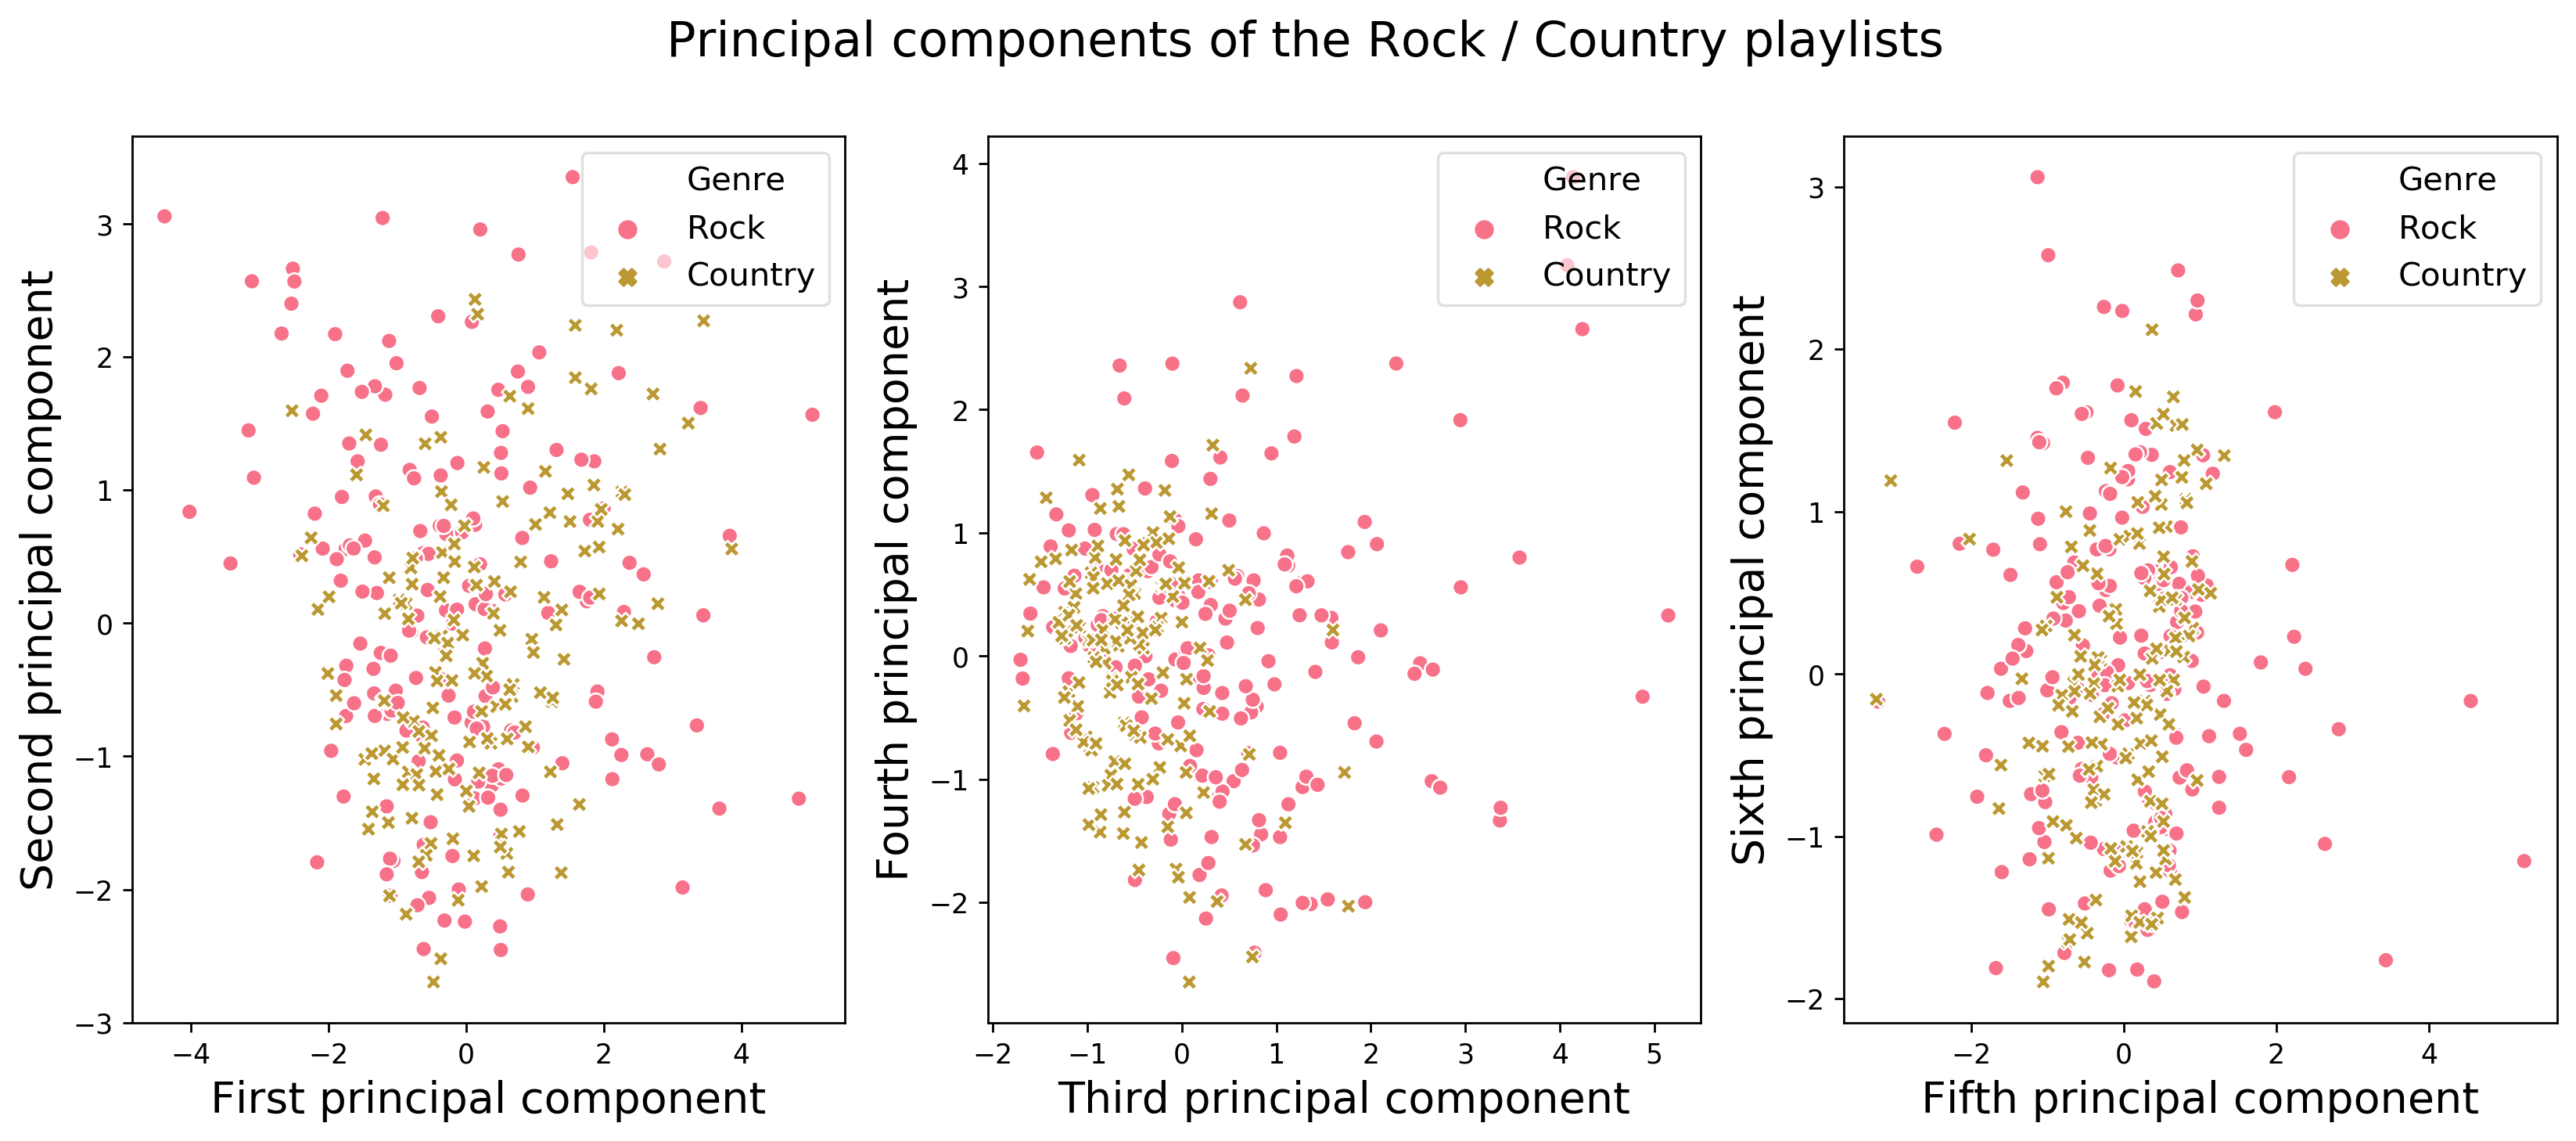

In [16]:
rrp_pca_fig = plot_principal_components(rock_rap_pca, rock_rap_df['Genre'], "Principal components of the Rock / Rap playlists")
crp_pca_fig = plot_principal_components(rap_country_pca, rap_country_df['Genre'], "Principal components of the Rap / Country playlists")
rco_pca_fig = plot_principal_components(rock_country_pca, rock_country_df['Genre'], "Principal components of the Rock / Country playlists")

### Step 5

As an additional step, let's see if there are better choices than the default solver `lbfgs`. We use `GridSearchCv` to iterate over some solvers and print their relative scores.

You'll see that `lbfgs` is either the best, or within one decimal place, so we don't make any changes.

In [17]:
def find_best_solver(playlist_df, x_cols, y_col):
    # TODO UPDATE DOCs
    """ Uses GridSearchSV to determine the best solver. Prints the relative scores.
    
        Parameters:
            - playlist_df - Spotify playlist dataframe. Should have all of the columns specified in x_cols, y_col
            - x_cols - Predictor columns. The columns used to train the logistic regression model. 
            - y_col - Target column. Distinguishes between the classes of the model.
    """
    # Split the data
    X = playlist_df[x_cols]
    Y = playlist_df[y_col]
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = TEST_SIZE, random_state = SEED)

    # Run logistic regression fitting over the possible solvers.
    hyper_params = dict(solver=LOG_REG_SOLVERS)
    log_reg_model = LogisticRegression(C=1, n_jobs=4, random_state=SEED)
    
    # Use GridSearchCV to loop over the hyperparameters.
    classifier = GridSearchCV(log_reg_model, hyper_params, cv=5)
    classifier.fit(x_train, y_train)
    best_model = classifier.best_estimator_
    
    # Show the scores of the solvers. Uncomment for-loop to print solver scores
    scores = classifier.cv_results_['mean_test_score']
    for score, solver in zip(scores, LOG_REG_SOLVERS):
        print(f"  {solver} {score:.3f}" )

In [18]:
print("Rock / Rap scores:")
find_best_solver(rock_rap_df, X_COLS, Y_COL)
print("Rap / Country scores:")
find_best_solver(rap_country_df, X_COLS, Y_COL)
print("Rock / Country scores:")
find_best_solver(rock_country_df, X_COLS, Y_COL)

Rock / Rap scores:
  liblinear 0.876
  newton-cg 0.876
  lbfgs 0.876
  sag 0.476
  saga 0.472
Rap / Country scores:
  liblinear 0.858
  newton-cg 0.844
  lbfgs 0.840
  sag 0.608
  saga 0.575
Rock / Country scores:
  liblinear 0.706
  newton-cg 0.698
  lbfgs 0.694
  sag 0.591
  saga 0.566


### Step 6 - Visualize the predictions

We take our predictions, and plot the relationship between the prediction probabilities, and the Logit of those same probabilities. Then we overlay the probabilities for each genre to get a sense for the separation between the two classses.

In [19]:
def plot_logit_relationship(df1, df2, df3):
    """ Plots scatterplots comparing 6 principal compontents: (1,2), (3,4), (5,6). Returns the figure for saving.

    Parameters:
        - pca_data: 2D array returned by PCA.transform, with at least 6 components
        - color_map: a mapping for colors and styles. Should be the same length as the first axis of pca_data
        - fig_title: A title for the figure.

    TODO - Refactor to take any number of dataframes.
    """
    fig, axes = plt.subplots(1, 3, figsize=(16, 5))
    fig.set_dpi(200)
    ax1, ax2, ax3 = axes.flatten()
    
    ax1.plot(logit(df1.p), df1.p, '--')
    ax1.plot(logit(df1.p), df1.genre, '+')
    ax2.plot(logit(df2.p), df2.p, '--')
    ax2.plot(logit(df2.p), df2.genre, '+')
    ax3.plot(logit(df3.p), df3.p, '--')
    ax3.plot(logit(df3.p), df3.genre, '+')
    
    ax1.set_xlabel("Logit(p)", fontsize=14)
    ax1.set_ylabel("p", rotation = 0, fontsize=14)
    ax1.set_title("Rock / Rap", fontsize=14)
    ax2.set_xlabel("Logit(p)", fontsize=14)
    ax2.set_ylabel("p", fontsize=14, rotation = 0,)
    ax2.set_title("Rap / Country", fontsize=14)
    ax3.set_xlabel("Logit(p)", fontsize=14)
    ax3.set_ylabel("p", fontsize=14, rotation = 0,)
    ax3.set_title("Rock / Country", fontsize=14)
    
    fig.suptitle("Probability of classifying songs into playlists", size = 18)
    return fig

In [20]:
rock_rap_test = rock_rap_test_data[0].copy()
rap_country_test = rap_country_test_data[0].copy()
rock_country_test = rock_country_test_data[0].copy()

rock_rap_test['genre'] = rock_rap_test_data[1]['genre_tag']
rock_rap_test['pred'] = rock_rap_test_data[2]
rock_rap_test['p'] = rock_rap_test_data[3]
rap_country_test['genre'] = rap_country_test_data[1]['genre_tag'] - 1 # Hack to make it {0, 1}
rap_country_test['pred'] = rap_country_test_data[2]
rap_country_test['p'] = rap_country_test_data[3]
rock_country_test['genre'] = rock_country_test_data[1]['genre_tag'] / 2 # Hack to make it {0, 1}
rock_country_test['pred'] = rock_country_test_data[2]
rock_country_test['p'] = rock_country_test_data[3]

rock_rap_logit = rock_rap_test.copy().sort_values(by = ['p'], axis = 0)
rap_country_logit = rap_country_test.copy().sort_values(by = ['p'], axis = 0)
rock_country_logit = rock_country_test.copy().sort_values(by = ['p'], axis = 0)

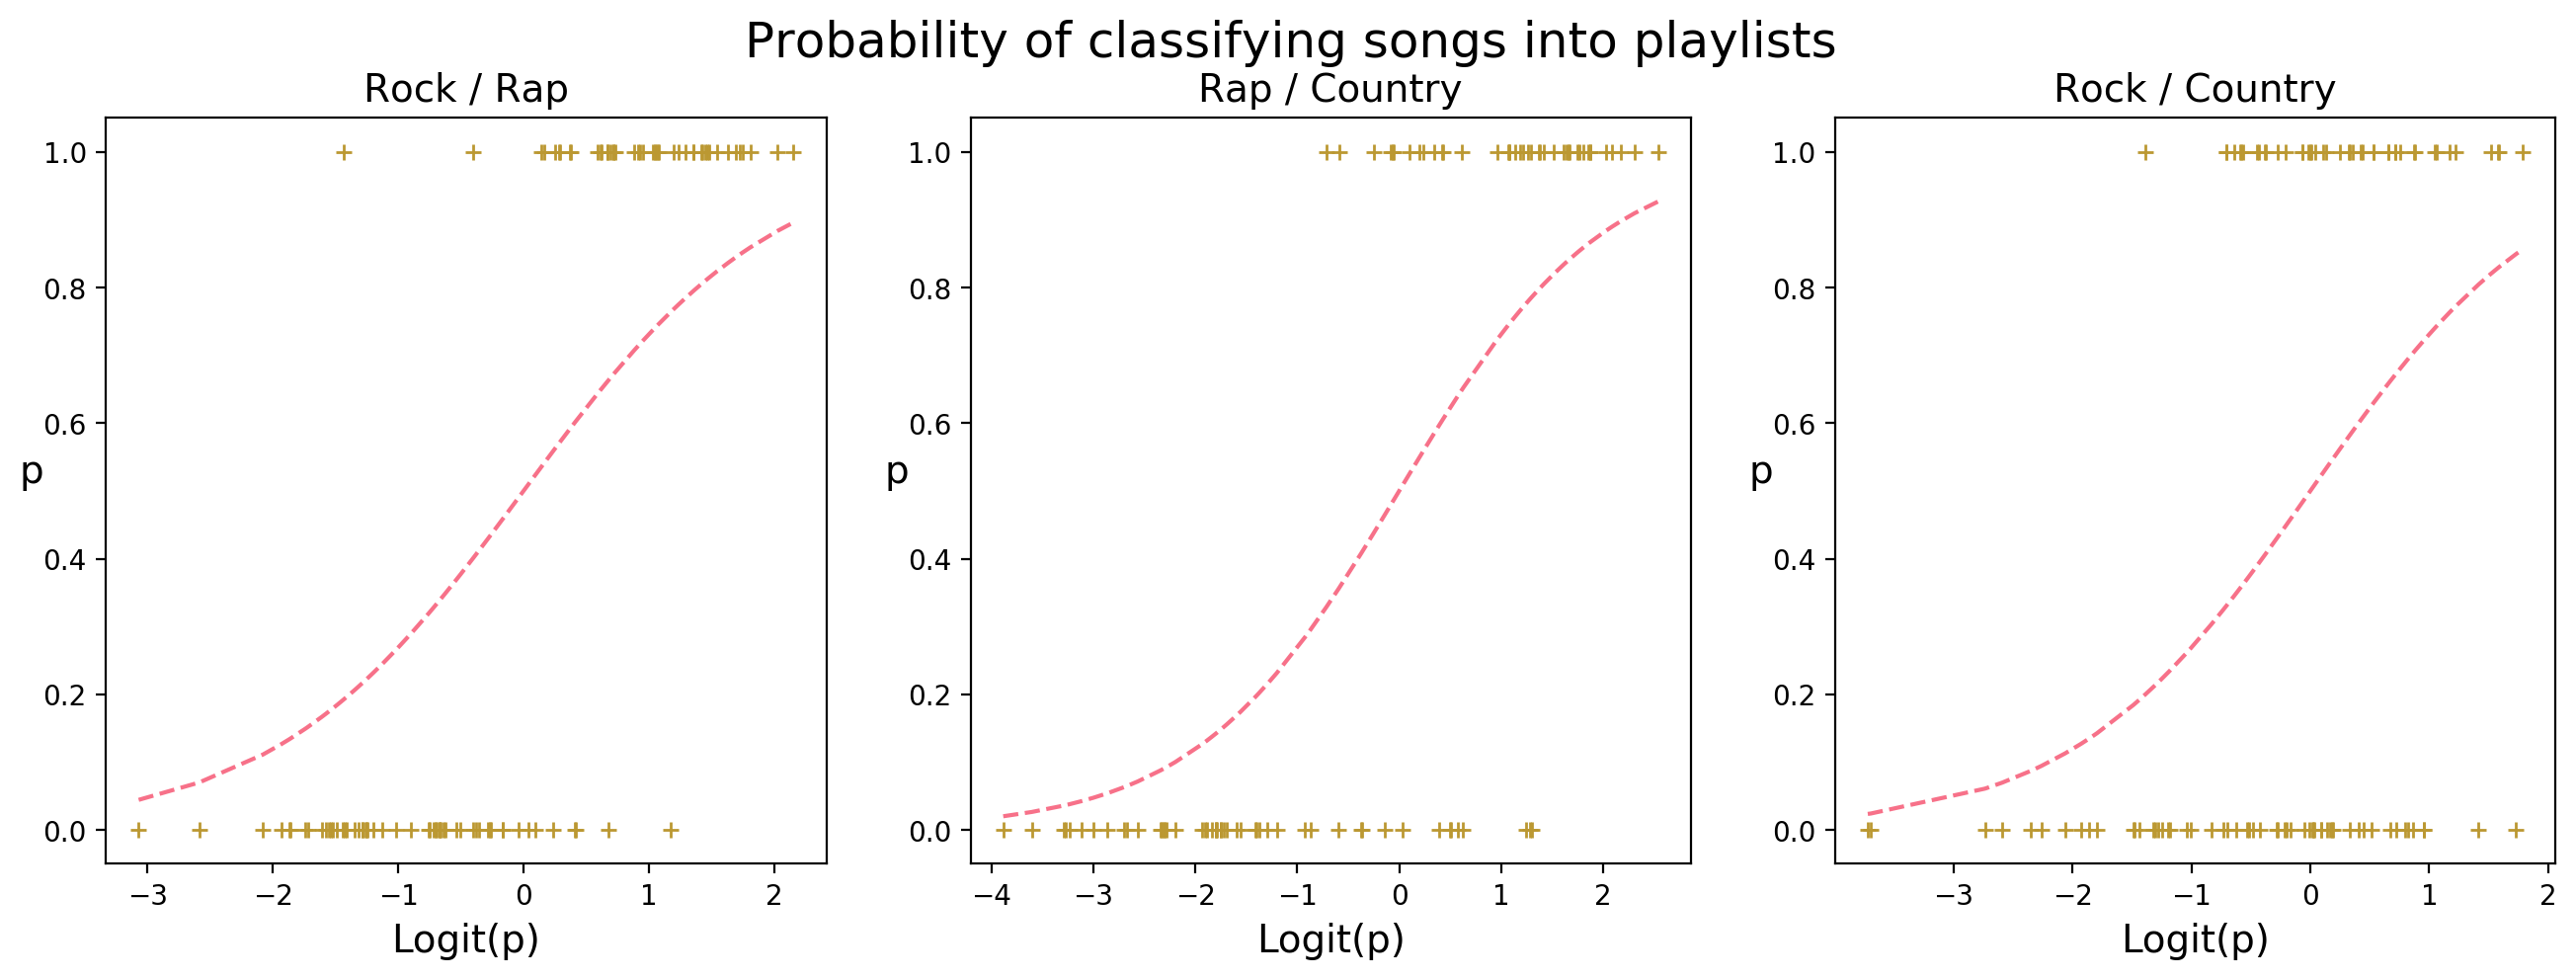

In [21]:
logit_fig = plot_logit_relationship(rock_rap_logit, rap_country_logit, rock_country_logit)

### Step 7

Wrap up the analysis. First, find some interesting data points likes the "most rock songs" and the "closest to country rap sang". Then save the plots for the blog post.

In [22]:
# For each comparison, find the songs for which the model believes is the most like and unlike its genre.
# e.g. which rock songs are the least like rock (the most like rap) and the most like rock (the least like rap)

# Since we dropped the URI data back in the logistic regression function, map the songs back to the original
# dataframe so we can look up the URIs.
rock_songs_least_rap = rock_rap_df.loc[rock_rap_test[rock_rap_test.genre == 0]
                                       .sort_values(by =['p'], ascending = False).head(3).index.values].id
rock_songs_most_rap = rock_rap_df.loc[rock_rap_test[rock_rap_test.genre == 0]
                                      .sort_values(by =['p'], ascending = True).head(3).index.values].id
rap_songs_least_rock = rock_rap_df.loc[rock_rap_test[rock_rap_test.genre == 1]
                                       .sort_values(by =['p'], ascending = False).head(3).index.values].id
rap_songs_most_rock = rock_rap_df.loc[rock_rap_test[rock_rap_test.genre == 1]
                                      .sort_values(by =['p'], ascending = True).head(3).index.values].id

rap_songs_least_country = rap_country_df.loc[rap_country_test[rap_country_test.genre == 0]
                                       .sort_values(by =['p'], ascending = False).head(3).index.values].id
rap_songs_most_country = rap_country_df.loc[rap_country_test[rap_country_test.genre == 0]
                                      .sort_values(by =['p'], ascending = True).head(3).index.values].id
country_songs_least_rap = rap_country_df.loc[rap_country_test[rap_country_test.genre == 1]
                                       .sort_values(by =['p'], ascending = False).head(3).index.values].id
country_songs_most_rap = rap_country_df.loc[rap_country_test[rap_country_test.genre == 1]
                                      .sort_values(by =['p'], ascending = True).head(3).index.values].id

rock_songs_least_country = rock_country_df.loc[rock_country_test[rock_country_test.genre == 0]
                                               .sort_values(by =['p'], ascending = False).head(3).index.values].id
rock_songs_most_country = rock_country_df.loc[rock_country_test[rock_country_test.genre == 0]
                                              .sort_values(by =['p'], ascending = True).head(3).index.values].id
country_songs_least_rock = rock_country_df.loc[rock_country_test[rock_country_test.genre == 1]
                                               .sort_values(by =['p'], ascending = False).head(3).index.values].id
country_songs_most_rock = rock_country_df.loc[rock_country_test[rock_country_test.genre == 1]
                                              .sort_values(by =['p'], ascending = True).head(3).index.values].id
                                              

## Rock Songs

**Least Rap**

1.   Another One Bites the Dust - Queen
2.   We Will Rock You - Queen
3.   Wolves - Missio

**Most Rap**

1.   Paradise City - Gins N' Roses
2.   Born to be Wild - Steppenwolf
3.   I Hate Myself for Loving You - Joan Jett

**Least Country**

1.   Old Time Rock & Roll - Bob Seger
2.   You Look Good Like That - Ferraro
3.   Wild Horses - The Rolling Stones

**Most Country**

1.   Born to be Wild - Steppenwolf
2.   Walk on the Wild Side - Lou Reed
3.   Radar Love - Golden Earring

## Rap songs

**Least Rock**

1.   We Paid - Lil Baby
2.   Money in the Grave - Drake
3.   Sum 2 Prove - Lil Baby

**Most Rock**

1.   After Party - Don Toliver
2.   The Woo - Pop Smoke
3.   Through The Wire - Rod Wave

**Least Country**

1.   Pinky Rosey - Perra
2.   Enemies - Post Malone
3.   Stargazing - Travis Scott

**Most Country**

1.   Pure Cocaine - Lil Baby
2.   10 Feaky Girls - Metro Boomin
3.   3 Headed Goat - Lil Durk

## Country songs

**Least Rap**
 
1.   Done - Chris Janson
2.   Timeless - Dallas Smith
3.   Heartarche Medication - Jon Pardi


**Most Rap**

1.   Miss Me More - Kelsea Ballerini
2.   I Should Probably Go To Bed - Dan + Shay
3.   Fall in Love - Josh Kerr

**Least Rock**

1.   One Thing Right - Marshmello
2.   Timeless - Dallas Smith
3.   Hearthache Medication - Jon Pardi

**Most Rock**

1.   We Back - Jason Aldean
2.   More Hearts Than Mine - Ingrid Andress
3.   Every Other Memory - Ryan Hurd

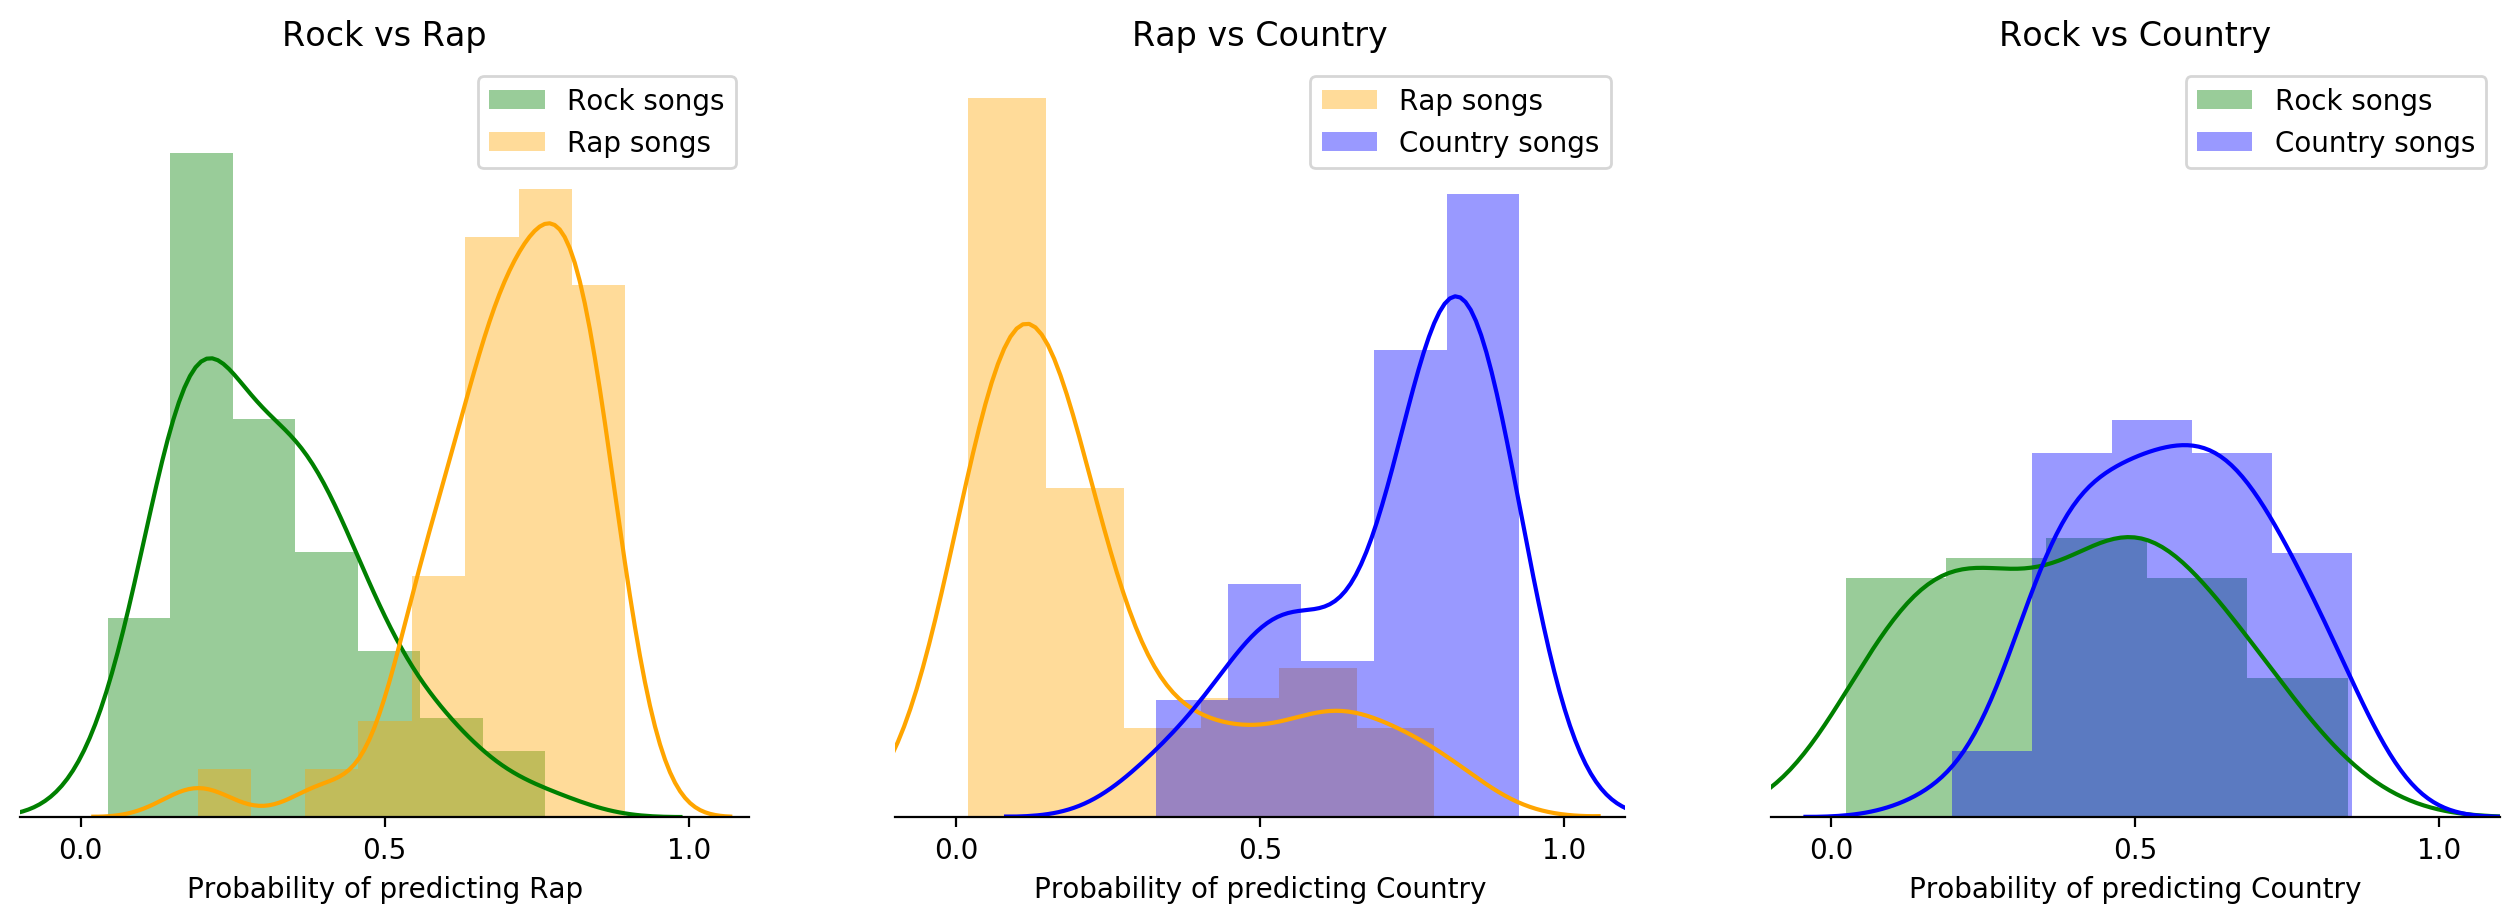

In [129]:
predictions_hist, ax = plt.subplots(1,3,figsize=(16,5), sharey=True)
predictions_hist.set_dpi(200)

ax1, ax2, ax3 = ax.flatten()
sns.distplot(rock_rap_logit[rock_rap_logit.genre==0].p, ax=ax1, label="Rock songs", color="g");
sns.distplot(rock_rap_logit[rock_rap_logit.genre==1].p, ax=ax1, label="Rap songs", color="orange");
ax1.set_title("Rock vs Rap")
ax1.set_xlabel("Probability of predicting Rap")

sns.distplot(rap_country_logit[rap_country_logit.genre==0].p, ax=ax2, label="Rap songs", color="orange");
sns.distplot(rap_country_logit[rap_country_logit.genre==1].p, ax=ax2, label="Country songs", color="b");
ax2.set_title("Rap vs Country")
ax2.set_xlabel("Probability of predicting Country")

sns.distplot(rock_country_logit[rock_country_logit.genre==0].p, ax=ax3, label="Rock songs", color="g");
sns.distplot(rock_country_logit[rock_country_logit.genre==1].p, ax=ax3, label="Country songs", color="b");
ax3.set_title("Rock vs Country")
ax3.set_xlabel("Probability of predicting Country")

for _ax in [ax1, ax2, ax3]:
    _ax.set(yticks = [], xticks=[0, 0.5, 1], xlim=[-0.1, 1.1]);

    _ax.spines["left"].set_visible(False)
    _ax.spines["top"].set_visible(False)
    _ax.spines["right"].set_visible(False)
    _ax.legend(loc=1);


In [130]:
logit_fig.savefig("plots/logits_all_playlists.png", dpi=300, bbox_inches='tight')
rrp_pca_fig.savefig("plots/rock_rap_pca.png", dpi=300, bbox_inches='tight')
crp_pca_fig.savefig("plots/country_rock_pca.png", dpi=300, bbox_inches='tight')
rco_pca_fig.savefig("plots/rock_country_pca.png", dpi=300, bbox_inches='tight')
predictions_hist.savefig("plots/predictions_hist.png", dpi=300, bbox_inches='tight')